# 고수준 API 구현 (텐서플로 2.x)

- **텐서플로 2.x에서 권장하는 방식**이다
- 빠른 생상성과, 훈련도구, 지원도구들이 많이 준비되어 있어서, 생산성이 아주 높다
- 텐서플로 1.x 기반에서 작성된 케라스코드를 사용한다면, **거의 변동 사항이 없다**

# 모듈 가져오기

In [1]:
import tensorflow as tf
tf.__version__

'2.6.0'

# 데이터 준비

In [2]:
from tensorflow.keras.datasets import mnist
import numpy as np

INPUT_CHANNEL = 1
(X_train, y_train), (X_test, y_test) = mnist.load_data()
PIXEL_H = X_train.shape[1]
PIXEL_W = X_train.shape[2]
PIXEL   = PIXEL_H * PIXEL_W
LABEL_NUM = len(np.unique(y_train))
# 최대값 기준 정규화
X_train = X_train/np.max(X_train)
X_test  = X_test/np.max(X_test)
# one-hot 인코딩
y_train = tf.keras.utils.to_categorical( y_train,  LABEL_NUM) 
y_test  = tf.keras.utils.to_categorical( y_test,  LABEL_NUM) 

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
PIXEL_H, PIXEL_W, PIXEL, LABEL_NUM

(28, 28, 784, 10)

In [4]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000, 10), (10000, 10))

In [5]:
#fmt, INPUT_CHANNEL

# 신경망 구성

- 신경망 구성에 만 집중하면, 그 연결은 자동으로 처리해준다

In [22]:
from tensorflow.keras import models, layers, backend
model = models.Sequential()
fmt   = backend.image_data_format()
if fmt == 'channels_last': 
  X_train      = X_train.reshape(-1, PIXEL_H, PIXEL_W, INPUT_CHANNEL )
  X_test       = X_test.reshape(-1, PIXEL_H, PIXEL_W, INPUT_CHANNEL )
  input_shape = ( PIXEL_H, PIXEL_W, INPUT_CHANNEL )
else:   
  X_train      = X_train.reshape(-1, INPUT_CHANNEL, PIXEL_H, PIXEL_W )
  X_test       = X_test.reshape(-1, INPUT_CHANNEL, PIXEL_H, PIXEL_W  )                   
  input_shape = ( INPUT_CHANNEL, PIXEL_H, PIXEL_W )

model.add( layers.Conv2D( 32,(5,5),(1,1),'same',activation  ='relu',  input_shape = input_shape ) )
model.add( layers.MaxPool2D( pool_size = (2, 2), strides   = None, padding   = 'same') )
model.add( layers.Dropout(0.1) )
model.add( layers.Conv2D( 32*2, (5,5),  padding='same', activation='relu' ) )
model.add( layers.MaxPool2D( padding   = 'same' ) )
model.add( layers.Dropout(0.1) )
model.add( layers.Flatten() )
model.add( layers.Dense( 1024, activation='relu')   )
model.add( layers.Dropout( 0.1) )
model.add( layers.Dense( LABEL_NUM, activation='softmax') )
model.compile(  
  optimizer='rmsprop',                         # 최적화 도구 , adam, sgd,...
  loss=tf.keras.losses.categorical_crossentropy,  # 손실함수
  metrics = ['accuracy']                       # 정확도
)

# 학습

- 여러가지 보조도구들을 제공하여 학습 성과를 높일수 있다

In [23]:
EPOCHS     = 10    
BATCH_SIZE = 128   

'''
- 훈련시 보조 도구 
- 조기학습종료
  - 손실 혹은 평가도구(metrics)상에서 더이상 개선되지 않으면, 훈련중지, 과적합 방지 역활
  - EarlyStopping
- 훈련 정보를 csv에 기록
  - CSVLogger
- 스케줄에 따라(계획에 따라) 학습률을 변경하는 역활
  - LearnningRateScheduler
- 텐서보드 기록
  - TensorBoard
- metrics 지표들이 개선이 되지 않는다면(정확도가 정체등등) -> 학습률을 조정한다
  - ReduceLROnPlateau
'''
# 훈련시 보조도구(콜백처리) 추가
from tensorflow.keras.callbacks import EarlyStopping,CSVLogger, LearningRateScheduler, ReduceLROnPlateau

# 학습률 lr 을 학습 세대의 횟수에 스케줄에 맞춰서 조절한다
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

early_stop = EarlyStopping()
learn_rate = LearningRateScheduler( scheduler )
reduce_lr_on_pl = ReduceLROnPlateau()
logger     = CSVLogger('train_log.csv')

#with tf.device('/device:GPU:0'):    
hist = model.fit( 
  X_train, 
  y_train, 
  batch_size=BATCH_SIZE, 
  epochs=EPOCHS,      
  validation_split=0.2,
  # 조기 학습 종료 추가
  callbacks = [ 
    early_stop,
    learn_rate, 
    reduce_lr_on_pl,
    logger,
    tf.keras.callbacks.TensorBoard('./logs_keras')
  ]
)

Epoch 1/10
 42/375 [==>...........................] - ETA: 2:33 - loss: 0.7738 - accuracy: 0.7610

KeyboardInterrupt: ignored

In [21]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000, 10))

# 예측

In [ ]:
# 테스트 데이터를 이용하여 예측
model.evaluate( X_test, y_test )

# 모델을 통해서 네트워크 확인

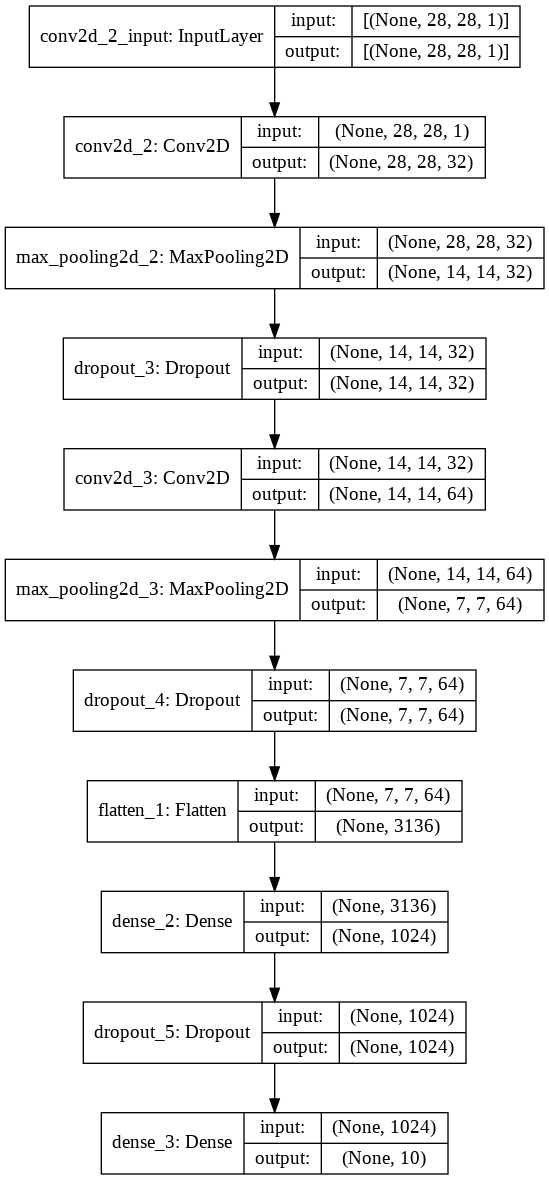

In [10]:
'''
  - 신경망 구성시 레이아웃(층) 구성과 shape의 변화를 일목요연하게 볼수 있다
'''
# 신경망의 구조(연결), 각 층의 shape(input, output), 각 층의 이름(합성곱,풀링, 클레스타입)
tf.keras.utils.plot_model( model, to_file='model.png', show_shapes=True, show_layer_names=True )

# 모델의 아킥첵쳐 확인

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)             

- 위의 요약을 정보를 확인 해본결과
  - Total params: 3,274,634  
    - 이 네트워크 구조상에 최적화 도구가 튜닝해야할 대상의 개수
  - Trainable params: 3,274,634
    - 실제 학습을 통해 최적화될 대상의 개수
  - Non-trainable params: 0
    - 학습에 대상이 아닌 파라미터

# 텐서보드상에 존재하는 정보를 추출하여서 저장

In [13]:
writer = tf.summary.create_file_writer('./model_logs')
with writer.as_default():
  tf.summary.scalar('custom.log', 10, step=3   )
  # ....

# 모델 저장

In [14]:
# 확장자는 다른것을 써도 되나, 저장되는 형식은 h5포멧을 따른다
# 따라서 통상적으로 확장자도 따란간다
'''
save_format: Either 'tf' or 'h5', indicating whether to save the
             model to Tensorflow SavedModel or HDF5. 
             Defaults to 'tf' in TF 2.X, and 'h5' in TF 1.X.
'''
model.save( 'my_model.tf' )

INFO:tensorflow:Assets written to: my_model.tf/assets


In [15]:
# save() 함수는 확장하 표현에 따라 저장 형식이 달라진다
model.save( 'my_model.h5' )

# 모델 로드

In [16]:
from keras.models import load_model

del model
model = load_model('my_model.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)             

# 가중치 저장

In [17]:
model.save_weights( 'my_model_only_w.h5' )